In [1]:
%load_ext autoreload
%autoreload 2

import json
import numpy as np
import geopandas as gpd
import tqdm.auto as tqdm
import pandas as pd
from permacache import stable_hash
import matplotlib.pyplot as plt
import collections
from urbanstats.geometry.shapefiles.shapefiles_list import shapefiles
from urbanstats.geometry.relationship import full_relationships
from urbanstats.special_cases.country import subnational_regions
from urbanstats.data.circle import overlapping_circles_fast
from urbanstats.website_data.table import shapefile_without_ordinals, compute_statistics_for_shapefile
from urbanstats.ordinals.compress_counts import uncompress_counts_sequence, compress_counts_sequence
from urbanstats.statistics.output_statistics_metadata import internal_statistic_names
from urbanstats.universe.universe_list import all_universes, default_universes
from urbanstats.geometry.relationship import ordering_idx as type_ordering_idx

/home/kavi/anaconda3/envs/urbanstats-310/lib/python3.10/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# ! pip install torch --index-url https://download.pytorch.org/whl/cpu

In [16]:
# t = shapefile_without_ordinals()

In [64]:
from urbanstats.games.quiz_region_types import QUIZ_REGION_TYPES_ALL
from urbanstats.games.quiz import minimum_population, filter_for_pop, stats_to_types, difficulty_multiplier, get_statistic_categories
from urbanstats.games.quiz_question_distribution import *

In [18]:
from collections import Counter
cat_sizes = Counter(get_statistic_categories().values())

In [19]:
# size_each = {k : available_questions[k][0].shape[0] for k in available_questions}

In [20]:
regions = QUIZ_REGION_TYPES_ALL
# regions = ["Judicial Circuit", "Country"]

In [21]:
geographies_by_type = {k: filter_for_pop(k) for k in regions}
all_stats = sorted({s for table, _ in geographies_by_type.values() for s in table}, key=str)
all_geographies = sorted({s for table, _ in geographies_by_type.values() for s in table.index}, key=str)
geo_weights = {s: 1 / table.shape[0] ** 0.5 for table, _ in geographies_by_type.values() for s in table.index}
stat_to_index = {k: i for i, k in enumerate(all_stats)}
geo_to_index = {k: i for i, k in enumerate(all_geographies)}

In [22]:
questions = []
for typ in tqdm.tqdm(regions):
    stats, universes = filter_for_pop(typ)
    questions.append(each_question(typ, stats, stat_to_index, geo_to_index))

  0%|          | 0/15 [00:00<?, ?it/s]

/home/kavi/census-centroid-blocks/population_density/urbanstats/games/quiz_question_distribution.py:38: RuntimeWarning: divide by zero encountered in divide
  np.abs(vals_a - vals_b) / np.minimum(np.abs(vals_a), np.abs(vals_b)) * 100
/home/kavi/census-centroid-blocks/population_density/urbanstats/games/quiz_question_distribution.py:38: RuntimeWarning: invalid value encountered in divide
  np.abs(vals_a - vals_b) / np.minimum(np.abs(vals_a), np.abs(vals_b)) * 100


In [23]:
questions_by_number = [ValidQuizQuestions.join(x) for x in zip(*questions)]

In [24]:
geo_target = np.array([geo_weights[g] for g in all_geographies])
geo_target /= geo_target.sum()
stat_target = np.array([1 / cat_sizes[get_statistic_categories()[s]] for s in all_stats])
stat_target /= stat_target.sum()

In [25]:
probability_array = []
normalization_ranges = []
starts = []
start = 0
for q in questions_by_number:
    probability_array.append(np.ones(len(q)))
    normalization_ranges.append(slice(start, start + len(q)))
    starts.append(start)
    start += len(q)
probability_array = np.concatenate(probability_array)

In [26]:
# import torch

# A = torch.zeros(5)
# x = torch.tensor([1.0, 1, 1], requires_grad=True)
# A.index_add_(0, torch.LongTensor([1, 1, 2]), x)
# A[2].backward()

In [57]:
gt = torch.tensor(geo_target, dtype=torch.float32)
st = torch.tensor(stat_target, dtype=torch.float32)

In [118]:
def kl(p, q):
    return (p * (torch.log(p) - torch.log(q))).sum()

In [124]:
qqp = QuizQuestionPossibilities(questions_by_number, all_geographies, all_stats)
p = torch.ones(len(qqp), requires_grad=True, dtype=torch.float32)
opt = torch.optim.Adam([p], lr=0.5)
prev = float("inf")
for idx in range(1000):
    g, s = qqp.aggregate_torch(p)
    loss = delta(st, s) + delta(gt, g)
    if idx % 10 == 0:
        print(idx, loss.item())
        if (loss.item() - prev) / prev > -0.05:
            break
        prev = loss.item()
    opt.zero_grad()
    loss.backward()
    opt.step()

0 2.6185712814331055
10 0.2629498541355133
20 0.1563507616519928
30 0.12732408940792084
40 0.11562307178974152
50 0.11458873748779297


In [125]:
g

tensor([0.0023, 0.0022, 0.0023,  ..., 0.0002, 0.0002, 0.0002],
       grad_fn=<DivBackward0>)

In [126]:
def renormalize_pdfs():
    for rang in normalization_ranges:
        probability_array[rang] /= probability_array[rang].sum()

In [127]:
questions_by_number[0].stat_indices.max()

195

In [128]:
# for _ in range(10):
#     renormalize_pdfs()
#     g = renormalize_by_geo(probability_array, normalization_ranges, questions_by_number, geo_target)
#     renormalize_pdfs()
#     s = renormalize_by_stat(probability_array, normalization_ranges, questions_by_number, stat_target)
#     print(mean_abs_geo(g), mean_abs_geo(s))
# # for _ in range(10):
# #     # renormalize_pdfs()
# #     s = renormalize_by_stat(probability_array, normalization_ranges, questions_by_number, stat_target)
#     print(mean_abs_geo(g), mean_abs_geo(s))


In [129]:
ga, sa = g.detach().numpy(), s.detach().numpy()

In [130]:
list(np.array(all_geographies)[ga < 1])

['10th Circuit, USA',
 '11th Circuit, USA',
 '1st Circuit, USA',
 '2nd Circuit, USA',
 '3rd Circuit, USA',
 '4th Circuit, USA',
 '5th Circuit, USA',
 '6th Circuit, USA',
 '7th Circuit, USA',
 '8th Circuit, USA',
 '9th Circuit, USA',
 'AK-00, USA',
 'AL-01, USA',
 'AL-02, USA',
 'AL-03, USA',
 'AL-04, USA',
 'AL-05, USA',
 'AL-06, USA',
 'AL-07, USA',
 'AR-01, USA',
 'AR-02, USA',
 'AR-03, USA',
 'AR-04, USA',
 'AZ-01, USA',
 'AZ-02, USA',
 'AZ-03, USA',
 'AZ-04, USA',
 'AZ-05, USA',
 'AZ-06, USA',
 'AZ-07, USA',
 'AZ-08, USA',
 'AZ-09, USA',
 'Abia, Nigeria',
 'Abidjan Urban Center, Ivory Coast',
 'Abidjan, Ivory Coast',
 'Abilene-Sweetwater TX Media Market, USA',
 'Abuja Federal Capital Territory, Nigeria',
 'Abū Z̧aby, United Arab Emirates',
 'Accra Urban Center, Ghana',
 'Aceh, Indonesia',
 'Ad Daqahlīyah, Egypt',
 'Ada County, Idaho, USA',
 'Adamawa, Nigeria',
 'Adams County, Colorado, USA',
 'Addis Ababa Urban Center, Ethiopia',
 'Afghanistan',
 'Agra Urban Center, India',
 'Aguad

In [131]:
pd.DataFrame(dict(geography=all_geographies, p=ga / geo_target)).sort_values("p")[:30]

,geography,p
1559,"Osaka [Kyoto] Urban Center, Japan",0.526555
1818,"Sana'a Urban Center, Yemen",0.531259
1117,"London Urban Center, United Kingdom",0.531657
1731,"Rio de Janeiro Urban Center, Brazil",0.535153
346,"Cairo Urban Center, Egypt",0.536464
500,"Damascus Urban Center, Syria",0.539414
1452,"New York Urban Center, USA",0.539698
2031,"Taiyuan Urban Center, China",0.542291
361,"Cape Town Urban Center, South Africa",0.543596
1968,"Sydney Urban Center, Australia",0.544060


In [133]:
pd.DataFrame(dict(geography=all_geographies, p=ga / geo_target)).sort_values("p")[-30:]

,geography,p
2234,"Windsor Population Center, ON, Canada",1.323498
1923,"St. Catharines - Niagara CMA, ON, Canada",1.334651
2154,"Victoria Population Center, BC, Canada",1.342318
1668,"Prince William County, Virginia, USA",1.347301
605,"Essex County, Ontario, Canada",1.351435
550,"Division No. 6, Saskatchewan, Canada",1.361028
547,"Division No. 11, Manitoba, Canada",1.369319
1119,"Longueuil Territory, Quebec, Canada",1.369448
2264,"York Regional municipality, Ontario, Canada",1.369686
1562,"Oshawa Population Center, ON, Canada",1.371721


In [134]:
pd.DataFrame(dict(statistic=all_stats, p=sa / stat_target)).sort_values("p")[-30:]

,statistic,p
64,heating_utility_gas,0.893793
136,mean_high_temp_spring_4,0.893802
188,transportation_means_walk,0.894890
3,ARTHRITIS_cdc_2,0.895165
5,BPHIGH_cdc_2,0.896550
17,KIDNEY_cdc_2,0.896644
24,VISION_cdc_2,0.899483
166,population_change_2000,0.899564
145,occupation_construction_and_extraction_occupat...,0.900437
109,industry_real_estate_and_rental_and_leasing,0.900935


In [138]:
pd.DataFrame(dict(statistic=all_stats, p=sa / stat_target)).sort_values("p")[:30]

,statistic,p
38,density_2021_pw_1_canada,0.694040
84,"industry_agriculture,_forestry,_fishing_and_hu...",0.765606
53,generation_genx_canada,0.775432
128,marriage_divorced_canada,0.787916
165,population_2021_canada,0.789956
86,"industry_arts,_entertainment,_and_recreation_c...",0.794037
55,generation_genz_canada,0.794806
114,industry_transportation_and_warehousing_canada,0.799573
57,generation_millenial_canada,0.801253
106,"industry_professional,_scientific,_and_technic...",0.801301


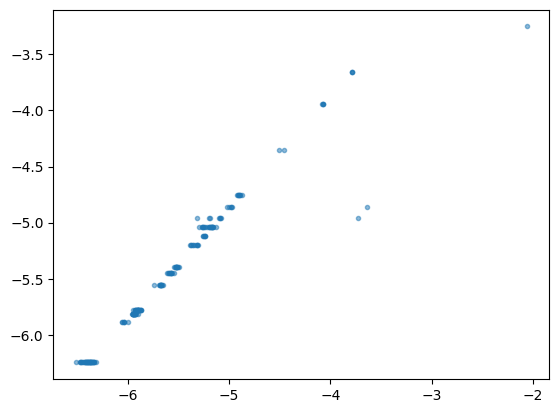

In [149]:
# plt.plot(np.log(sa))
# plt.plot(np.log(stat_target))
plt.scatter(np.log(sa), np.log(stat_target), alpha=0.5, marker=".")

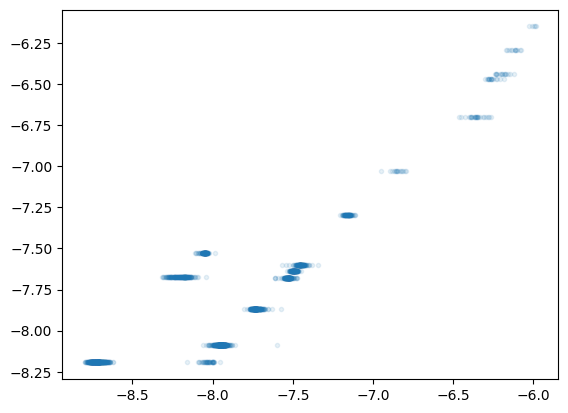

In [146]:
plt.scatter(np.log(ga), np.log(geo_target), alpha=0.1, marker=".")

In [127]:
renormalizers

array([1.00847893, 1.00239669, 1.00329174, ..., 1.00091969, 1.01323398,
       0.98950264])

In [13]:
from scipy.sparse import coo_array

In [14]:
[len(qs) / 1e6 for qs in questions_by_number]

[1.389935, 1.44549, 2.128123, 3.388021, 13.646391]

In [255]:
import cvxpy as cp

In [256]:
question_weights = [cp.Variable(len(qs)) for qs in questions_by_number]

In [258]:
constraints = []
constraints += [q.sum() == 1 for q in question_weights]
constraints += [question_index_constraint(questions_by_number, question_weights, len(geo_to_index))]
# constraints += [statistics_constraint(questions_by_number, question_weights, len(stat_to_index))]
entropy = sum(cp.entr(q).sum() for q in question_weights)

In [259]:
prob = cp.Problem(cp.Maximize(entropy), constraints)
# soln = prob.solve(verbose = True)
# assert prob.status == 'optimal'

In [262]:
help(prob.solve)

Help on method solve in module cvxpy.problems.problem:

solve(*args, **kwargs) method of cvxpy.problems.problem.Problem instance
    Compiles and solves the problem using the specified method.
    
    Populates the :code:`status` and :code:`value` attributes on the
    problem object as a side-effect.
    
    Arguments
    ---------
    solver : str, optional
        The solver to use. For example, 'CLARABEL', 'SCS', or 'OSQP'.
    solver_path : list of (str, dict) tuples or strings, optional
        The solvers to use with optional arguments.
        The function tries the solvers in the given order and
        returns the first solver's solution that succeeds.
        For example, ['SCS', ('OSQP', {'max_iter':10000})]
    verbose : bool, optional
        Overrides the default of hiding solver output, and prints
        logging information describing CVXPY's compilation process.
    gp : bool, optional
        If True, parses the problem as a disciplined geometric program
        in

In [263]:
daha = prob.get_problem_data(solver='CLARABEL')

In [264]:
with open("/home/kavi/temp/temp.pkl", "wb") as f:
    import pickle; pickle.dump(daha, f)

In [ ]:
prob.status

In [337]:
question_weights[0].value

In [338]:
question_weights[0].value

In [339]:
questions_by_number[0].stat_indices.min()

25

In [340]:
adj_d = compute_adjusted_difficulties(typ, stats)

In [98]:
adj_d.shape

(155, 192, 192)

In [46]:
# vals_a, vals_b = values_non_nan[:, None], values_non_nan[None]

/tmp/ipykernel_1711432/1339730407.py:1: RuntimeWarning: divide by zero encountered in divide
  raw_pct_diff = np.abs(vals_a - vals_b) / np.minimum(np.abs(vals_a), np.abs(vals_b)) * 100
/tmp/ipykernel_1711432/1339730407.py:1: RuntimeWarning: invalid value encountered in divide
  raw_pct_diff = np.abs(vals_a - vals_b) / np.minimum(np.abs(vals_a), np.abs(vals_b)) * 100


In [90]:
((5 < adj_pct_diff) & (adj_pct_diff < 40)).sum()

2684208